In [142]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
plt.rcParams['figure.dpi'] = 100

# 0. Load location and groupings information

In [33]:
## Read samples location info
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'dc_222_samples_info.tsv'
file_data = glob(dir_path + file_name)[0]
INFO = pd.read_csv(file_data, sep='\t')[['sample_ID', 'rookery-region', 'Year', 'group-Lkadj', 
                                         'Management units - based on DNA', 'Post_dupe_depth_2_all_LKGATK_USE',
                                         'Exclude-all_GL_ROH_analyses', 'Sequencing_source-type']]
INFO.rename(columns={'sample_ID':'sample', 
                     'rookery-region':'rookery', 
                     'Year':'year',
                     'group-Lkadj': 'group',
                     'Management units - based on DNA': 'MU',
                     'Post_dupe_depth_2_all_LKGATK_USE':'depth',
                     'Exclude-all_GL_ROH_analyses': 'exclude',
                     'Sequencing_source-type': 'batch'}, inplace=True)

## 0.1 Define colors

In [120]:
rookery_palette_dict = {
    'Mexico': '#1f77b4',
    'Atl Costa Rica': '#005a32',
    'Indonesia': '#d62728',
    'Pacific Costa Rica': '#7570b3',
    'Papua New Guinea': '#dd3497',
    'Solomon Islands': '#fde0dd',
    'Malaysia': '#2ca02c',
    'South Africa': '#17becf',
    'Ghana': '#ff7f0e',
    'Gabon': '#fdd0a2',   
    'French Guiana-Suriname': '#8c564b',
    'Virgin Islands': '#6a51a3',
    'Florida': '#d9f0a3',
    'na': '#000000',
    'unknown': '#7f7f7f'}

mu_palette_dict = {
    'Eastern Pacific': '#1f77b4',
    'Western Pacific': '#d62728',
    'Northwest Caribbean': '#005a32',
    'Northeast Caribbean': '#6a51a3',
    'Northern Caribbean': '#d9f0a3',
    'South Africa': '#17becf',
    'SE Atlantic/West Africa': '#ff7f0e',
    'South-east Caribbean': '#8c564b',
    'Indo-Western Pacific': '#2ca02c',
    'na': '#000000',
    'unknown': '#7f7f7f'}

batch_palette_dict = {
    'novo_UMass_Illumina_SR': '#1f77b4',
    'novo42_Illumina_SR': '#ff7f0e',
    'LR-getinfofromJH': '#2ca02c',
    'Duffy_Illumina_SR': '#d62728'}

population_palette_dict = {
    'larger_declining': '#d62728',
    'small_stable':'#1f77b4',
    'small_declining': '#005a32',
    'larger_stable': '#ff7f0e',
    'small_recovering': '#6a51a3'}

color_dict = {'MU': mu_palette_dict,
              'rookery': rookery_palette_dict,
              'batch': batch_palette_dict,
              'pops': population_palette_dict}

# 1. Genome-wide heterozygosity

In [156]:
## Read summary file with total number of variants by impact
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'Heterozygosity_222/all_samples.hets.all.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Compute heterozigosity
df['f_hets'] = df['hets'] / df['total']

## Assign location info to each sample
df_all = pd.merge(df, INFO, on='sample')

## Exclude samples that are not for genetic load analysis
df_all['exclude'] = df_all['exclude'].fillna('include')

df_all.head(3)

,sample,hets,total,variants,f_hets,rookery,year,group,MU,depth,exclude,batch
0,dc_11130,967398,1929780,variants,0.501300,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,exclude,novo_UMass_Illumina_SR
1,dc_11130,774960,1283008,snps,0.604018,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,exclude,novo_UMass_Illumina_SR
2,dc_11137,955561,1873692,variants,0.509988,Mexico,1995.0,larger_declining,Eastern Pacific,11.50,exclude,novo_UMass_Illumina_SR


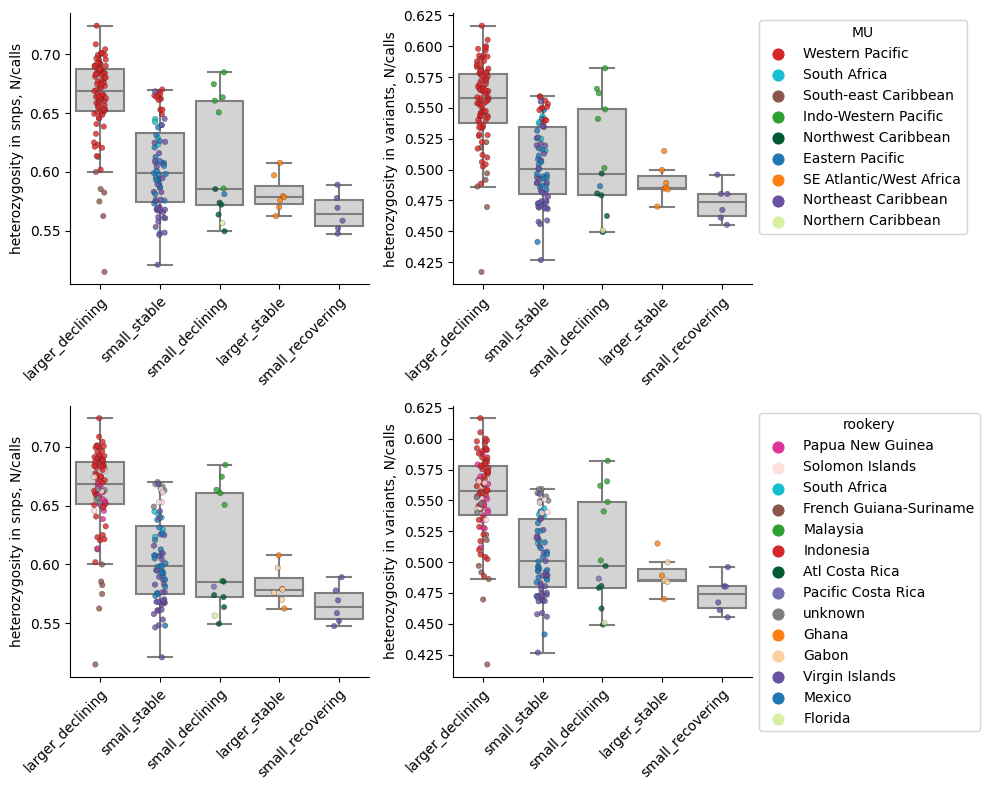

In [160]:
fig, axes = plt.subplots(2, 2, figsize = (10, 8))

groups = ['MU', 'rookery']
variants = set(df_all['variants'])

for j in range(len(groups)):
    for i, variant in enumerate(variants):
   
        axi = axes[j, i]
        dfi = df_all[df_all['variants'] == variant]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]
        p = color_dict[group]

        sns.boxplot(ax=axi, data=dfi, x='group', y='f_hets', showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y='f_hets', hue=group, 
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'heterozygosity in {variant}, N/calls')
        axi.set_xlabel('')

        if i != 1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## Plot main groups only

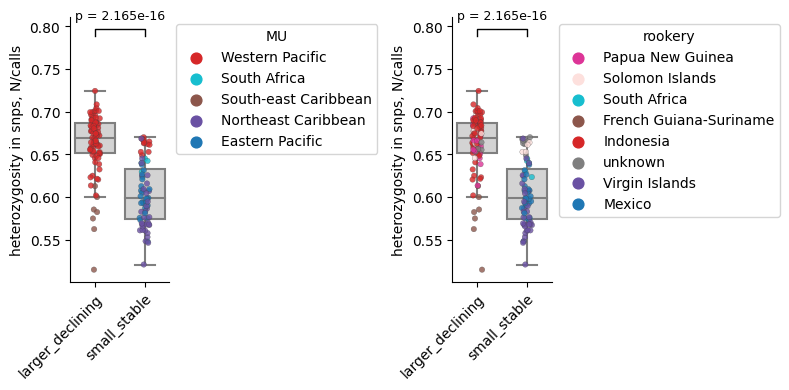

In [170]:
groups = ['MU', 'rookery']
variant = 'snps'
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for j in range(len(groups)):
    axi = axes[j]
    dfi = df_all[df_all['variants'] == variant]
    dfi = dfi[dfi['exclude'] == 'include']
    dfi = dfi[dfi['group'].isin(pops)]

    group = groups[j]
    p = color_dict[group]

    # Subset data per population
    data1 = dfi[dfi['group'] == g1]['f_hets']
    data2 = dfi[dfi['group'] == g2]['f_hets']

    # Perform Mann–Whitney U test
    stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')

    # Boxplot and stripplot
    sns.boxplot(ax=axi, data=dfi, x='group', y='f_hets', showfliers=False, color="lightgrey")
    sns.stripplot(ax=axi, data=dfi, x='group', y='f_hets', hue=group,
                  alpha=0.8, s=4, linewidth=0.2, palette=p)

    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_ylabel(f'heterozygosity in {variant}, N/calls')
    axi.set_xlabel('')

    # Add bar and p-value
    y_max = max(dfi['f_hets']) * 1.1
    axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
    axi.text(0.5, y_max * 1.01, f"p = {pval:.3e}", ha='center', va='bottom', fontsize=9)

    sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()


## 1.1. Variant density, per Mb

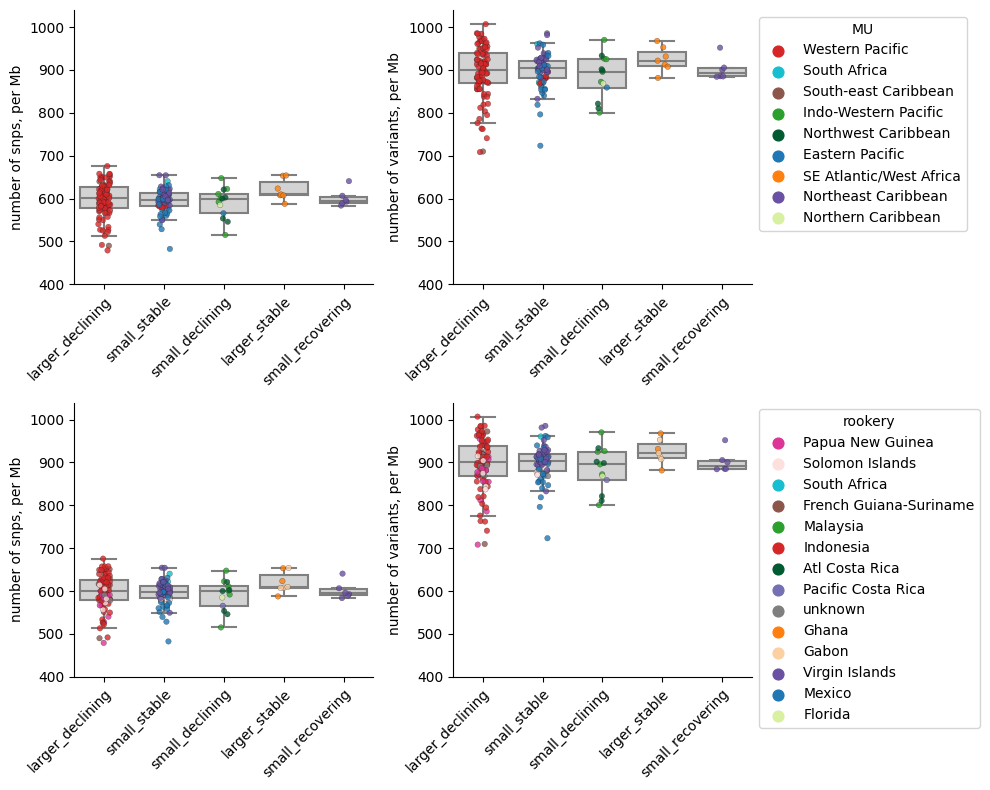

In [171]:
L_genome = 2_164.762090
df_all['diversity'] = df_all['total'] / L_genome

fig, axes = plt.subplots(2, 2, figsize = (10, 8))
groups = ['MU', 'rookery']
variants = set(df_all['variants'])

for j in range(len(groups)):
    for i, variant in enumerate(variants):
   
        axi = axes[j, i]
        dfi = df_all[df_all['variants'] == variant]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]
        p = color_dict[group]

        sns.boxplot(ax=axi, data=dfi, x='group', y='diversity', showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y='diversity', hue=group, 
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'number of {variant}, per Mb')
        axi.set_xlabel('')
        axi.set_ylim(400, 1040)

        if i != 1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## Plot main groups only

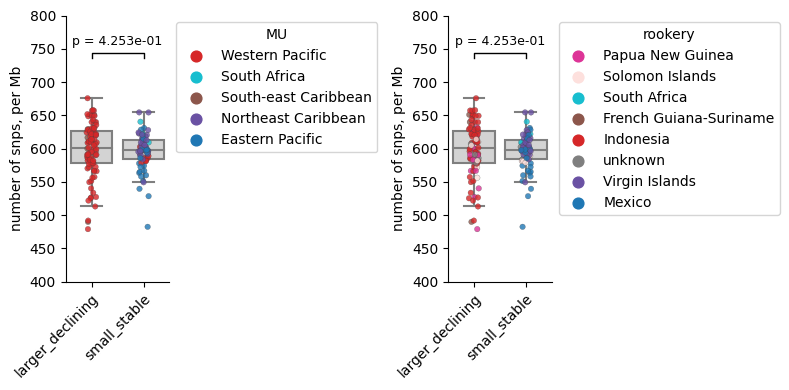

In [172]:
groups = ['MU', 'rookery']
variant = 'snps'
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for j in range(len(groups)):
    axi = axes[j]
    dfi = df_all[df_all['variants'] == variant]
    dfi = dfi[dfi['exclude'] == 'include']
    dfi = dfi[dfi['group'].isin(pops)]

    group = groups[j]
    p = color_dict[group]

    # Subset data per population
    data1 = dfi[dfi['group'] == g1]['diversity']
    data2 = dfi[dfi['group'] == g2]['diversity']

    # Perform Mann–Whitney U test
    stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')

    sns.boxplot(ax=axi, data=dfi, x='group', y='diversity', showfliers=False, color="lightgrey")
    sns.stripplot(ax=axi, data=dfi, x='group', y='diversity', hue=group, 
                  alpha=0.8, s=4, linewidth=0.2, palette=p)

    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_ylabel(f'number of {variant}, per Mb')
    axi.set_xlabel('')
    axi.set_ylim(400, 800)

    # Add bar and p-value
    y_max = max(dfi['diversity']) * 1.1
    axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
    axi.text(0.5, y_max * 1.01, f"p = {pval:.3e}", ha='center', va='bottom', fontsize=9)

    sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# 2. Sliding window heterozygosity: window = 1Mb, step = 100kb

In [11]:
## Read summary file with total number of variants by impact
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'Heterozygosity_222/all_sliding_window_hets.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

df['sample'] = df['sample'].astype(str)

## Compute heterozigosity
df['f_hets'] = df['hets'] / df['calls']

## Assign location info to each sample
df_all = pd.merge(df, INFO, on='sample')

## Exclude samples that are not for genetic load analysis
# df_all['exclude'] = df_all['exclude'].fillna('include')

df_all.head(3)

,chrom,window_start,sites_total,calls,hets,sample,f_hets,rookery,year,group,MU,depth,exclude,batch
0,SUPER_10,1,824,824,764,23560,0.927184,Virgin Islands,2000.0,small_recovering,Northeast Caribbean,12.5763,NaN,LR-getinfofromJH
1,SUPER_10,100001,837,837,790,23560,0.943847,Virgin Islands,2000.0,small_recovering,Northeast Caribbean,12.5763,NaN,LR-getinfofromJH
2,SUPER_10,200001,838,838,786,23560,0.937947,Virgin Islands,2000.0,small_recovering,Northeast Caribbean,12.5763,NaN,LR-getinfofromJH


## 2.1. Plot sliding window for one sample

In [12]:
def make_position(dfi, col_chr, col_start):
    ## sorts by chromosome number and adds absolute postion column
    
    exclude = ['chrZ', 'chrW', 'chrNA', 'chrMT']
    dfi['COUNT'] = dfi[col_chr].str.replace('scaffold_', '')
    dfi['COUNT'] = dfi[col_chr].str.replace('SUPER_', '')
    
    dfi_num = dfi[ ~dfi[col_chr].isin(exclude)]
    dfi_Z = dfi[dfi[col_chr] == 'chrZ']
    dfi_W = dfi[dfi[col_chr] == 'chrW']
    
    dfi_num['COUNT'] = pd.to_numeric(dfi_num['COUNT'])
    dfi_num = dfi_num.sort_values(by=['COUNT', col_start])

    dfi_merged = pd.concat([dfi_num, dfi_Z, dfi_W], ignore_index=True)
    dfi_merged['POSITION'] = [x / 10 for x in range(dfi_merged.shape[0])]
    return dfi_merged

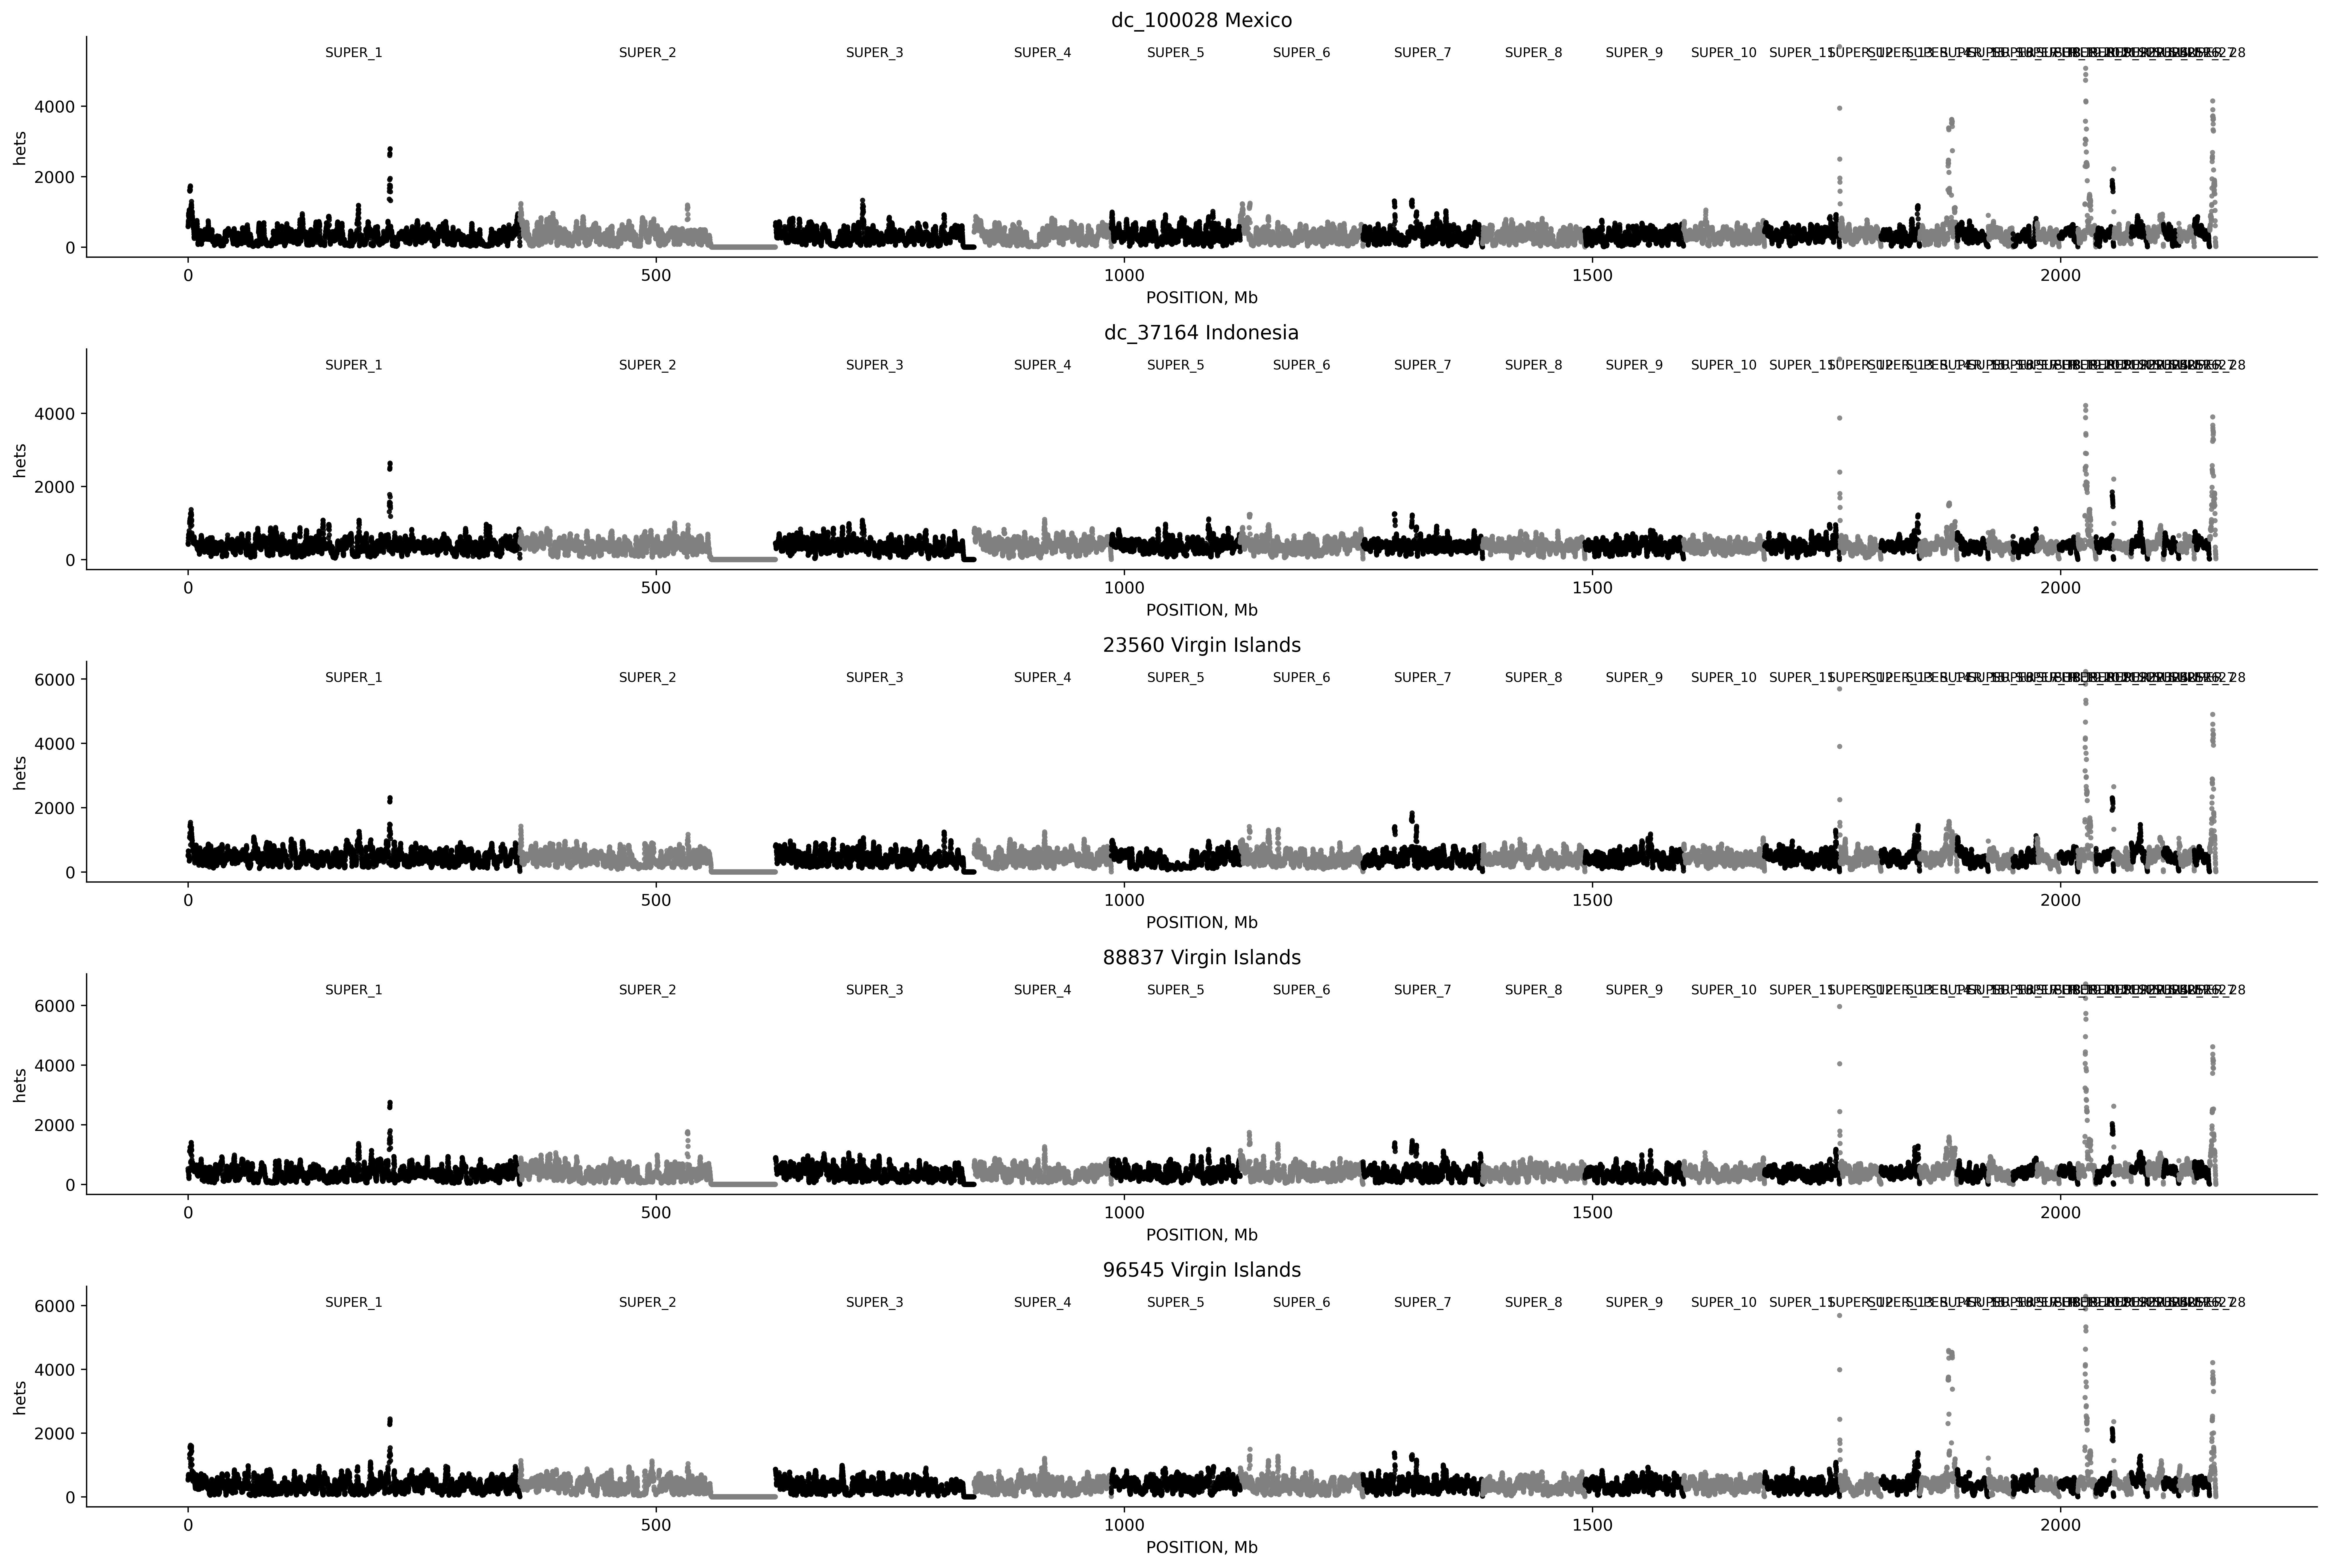

In [13]:
warnings.filterwarnings('ignore')

samples = ['dc_100028', 'dc_37164', '23560', '88837', '96545']

fig, axes = plt.subplots(len(samples), 1, figsize=(20, 2.7*len(samples)))

for i in range(len(samples)):
    sample = samples[i]
    axi = axes[i]
    dfi = df_all[df_all["sample"] == sample]
#     dfi = dfi[dfi['chrom'].isin(['SUPER_1', 'SUPER_6', 'SUPER_7'])]
#     dfi = dfi[dfi['chrom'].isin(['SUPER_6'])]
   
    df_merged = make_position(dfi, 'chrom', 'window_start')

    N = len(set(df_merged['COUNT']))
    p = (['black', 'grey'] * (int(N / 2) + 1))[:N]

    sns.scatterplot(ax=axi, data=df_merged, x='POSITION', y='hets', hue='chrom', 
                    s=10, linewidth=0, alpha=0.9, palette=p)

    # Get midpoints for each chromosome
    chr_mids = df_merged.groupby('chrom')['POSITION'].agg(['min', 'max'])
    chr_mids['mid'] = (chr_mids['min'] + chr_mids['max']) / 2

    # Add labels at midpoints
    for chrom, row in chr_mids.iterrows():
        axi.text(row['mid'], axi.get_ylim()[1]*0.95, chrom, 
                 ha='center', va='top', fontsize=8, color='black')

    sns.despine(ax=axi)
    axi.legend([], [], frameon=False)
    rookery = list(set(dfi['rookery']))[0]
    axi.set_title(f'{sample} {rookery}')
    axi.set_xlabel('POSITION, Mb')

fig.tight_layout()

# 3. ROH = f(heterozygosity)

In [173]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'ROH_222/all_samples_binned_ROH.tsv'
file_data = glob(dir_path + file_name)[0]
df_roh = pd.read_csv(file_data, sep='\t')
df_roh['L_total'] = df_roh['L_less100'] + df_roh['L_100_500'] + df_roh['L_more500']

## Assign location to each sample
df_all_roh = pd.merge(df_roh, df_all, on='sample')
df_all_roh.head(3)

,sample,round,number_ROH,L_less100,L_100_500,L_more500,L_total,hets,total,variants,f_hets,rookery,year,group,MU,depth,exclude,batch,diversity
0,Z005878,from_Lisa_window_20,10232,390751.609,835036.509,78925.356,1304713.474,622861,1356111,variants,0.459299,Pacific Costa Rica,1994.0,larger_declining,Eastern Pacific,6.22,exclude,novo42_Illumina_SR,626.448055
1,Z005878,from_Lisa_window_20,10232,390751.609,835036.509,78925.356,1304713.474,483831,905088,snps,0.534568,Pacific Costa Rica,1994.0,larger_declining,Eastern Pacific,6.22,exclude,novo42_Illumina_SR,418.100448
2,Z005882,from_Lisa_window_20,7905,287180.462,693287.245,70653.806,1051121.513,954868,1925026,variants,0.496029,Pacific Costa Rica,1994.0,larger_declining,Eastern Pacific,10.18,exclude,novo42_Illumina_SR,889.255225


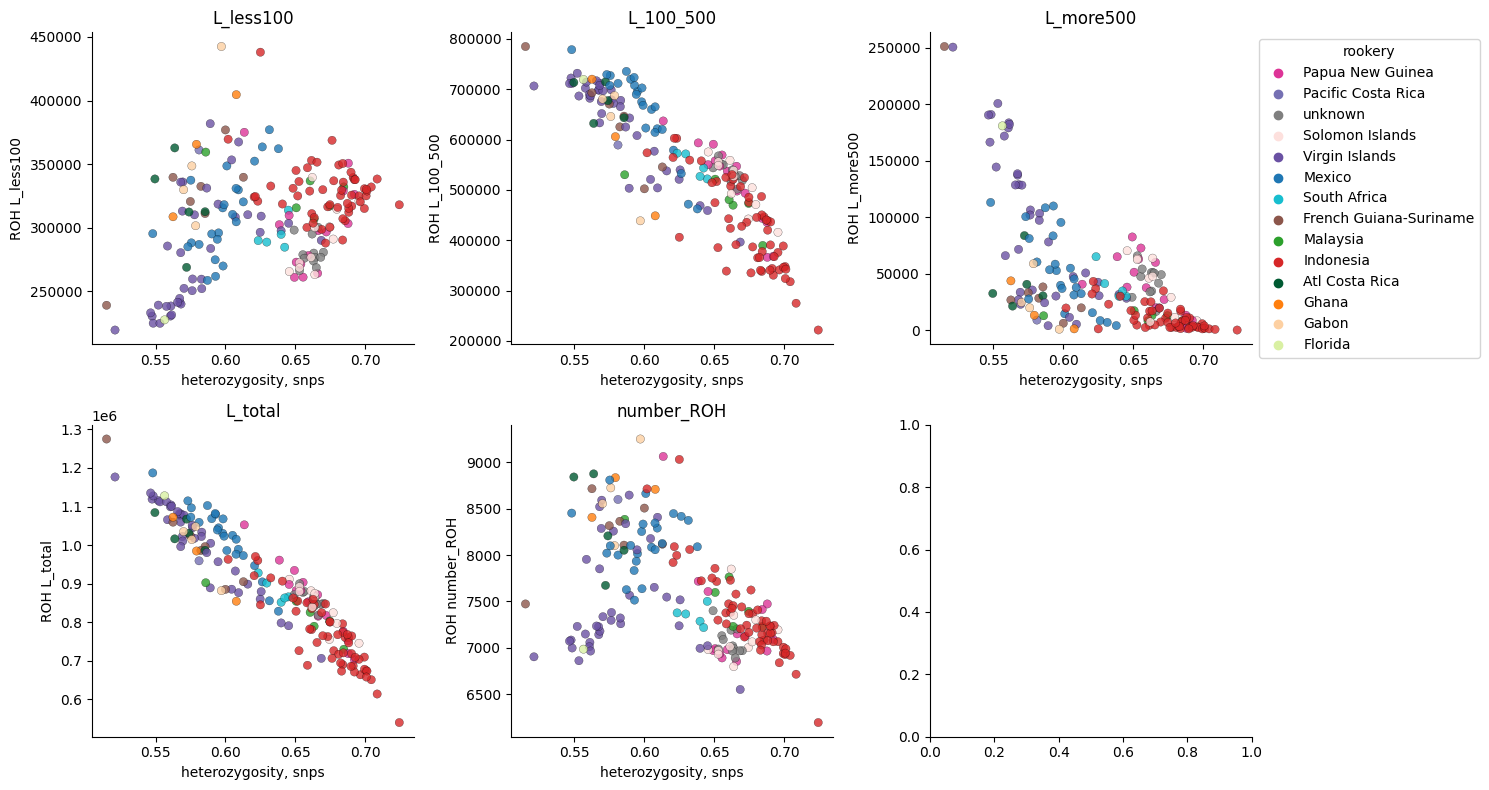

In [175]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
p = color_dict['rookery']

## select only one round of PLINK ROH params
q = 20
round_q = 'from_Lisa_window_{}'.format(q)
df_temp = df_all_roh[df_all_roh['round'] == round_q]

## select only snps
var = 'snps'
df_temp = df_temp[(df_temp['variants'] == var)]
df_temp = df_temp[df_temp['exclude'] == 'include']

values = ['L_less100', 'L_100_500', 'L_more500', 'L_total', 'number_ROH']

for k in range(len(values)):
    i = k % 3
    j = k // 3
    v = values[k]
    axi = axes[j][i]
    
    sns.scatterplot(ax=axi, data=df_temp, x='f_hets', y=v, hue=group, 
                    alpha=0.8, edgecolor='k', linewidth=0.2, palette=p)
    
    axi.set_title(v)
    axi.set_ylabel(f'ROH {v}')
    axi.set_xlabel('heterozygosity, snps')
    if i != 2:
        axi.get_legend().set_visible(False)
    else:
        sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## Plot main groups only

In [178]:
pvals = []
value_stats = []

# Step 1: Collect all p-values
for v in values:
    dfi = df_temp[df_temp['group'].isin(pops)]
    data1 = dfi[dfi['group'] == g1][v]
    data2 = dfi[dfi['group'] == g2][v]
    
    # Mann–Whitney U test
    stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
    pvals.append(pval)
    value_stats.append((v, stat))

# FDR correction
rej, qvals, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

# Zip them together
value_to_qval = {v: q for (v, _), q in zip(value_stats, qvals)}

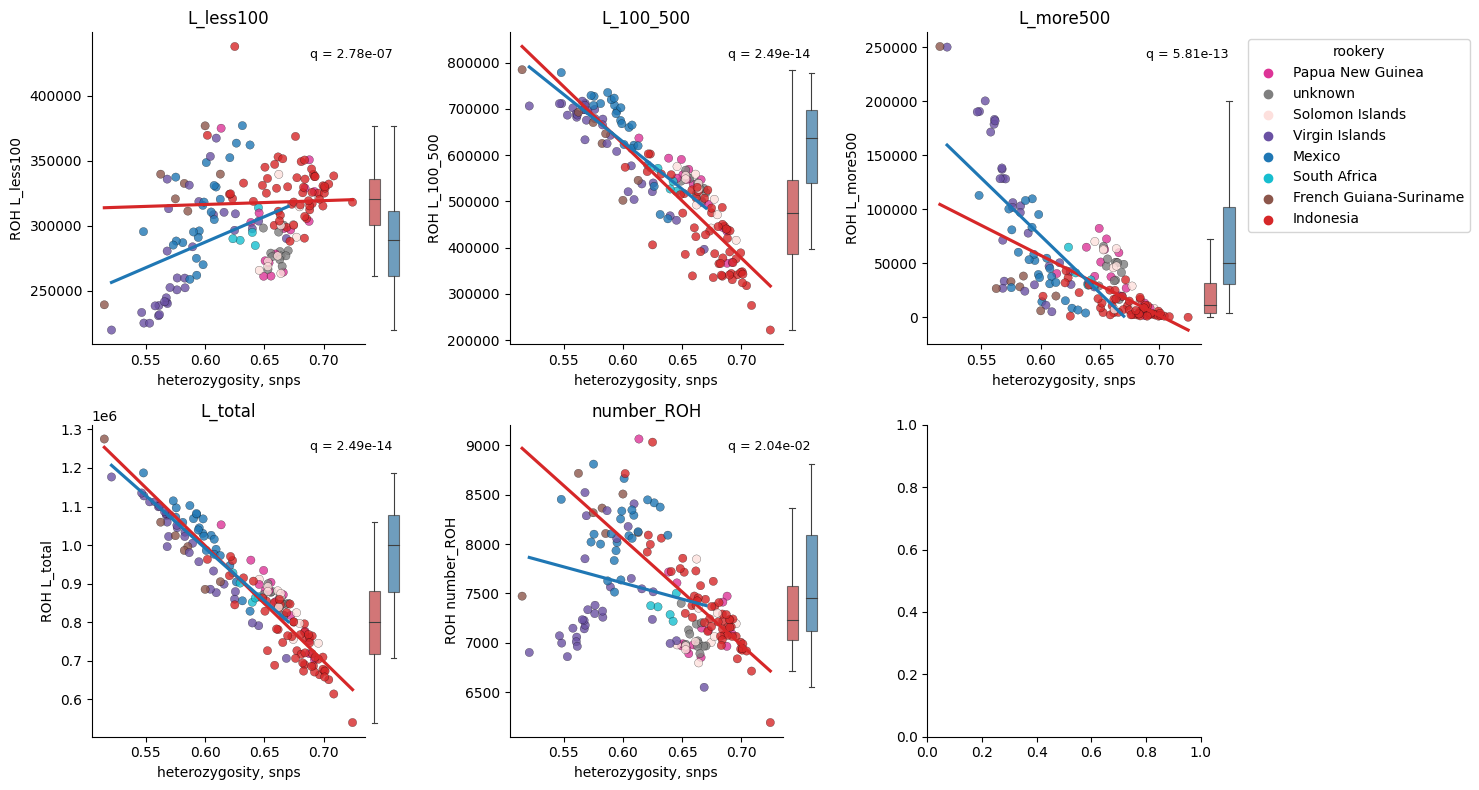

In [179]:
values = ['L_less100', 'L_100_500', 'L_more500', 'L_total', 'number_ROH']
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]
group = 'rookery'

# define colors
p = color_dict[group]
p0 = color_dict['pops']
c1 = p0[g1]
c2 = p0[g2]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for k in range(len(values)):
    i = k % 3
    j = k // 3
    v = values[k]
    ax_main = axes[j][i]

    dfi = df_temp[df_temp['group'].isin(pops)]

    # Scatterplot + regression lines
    sns.regplot(ax=ax_main, data=dfi[dfi['group'] == g1], x='f_hets', y=v, scatter=False, color=c1, ci=None)
    sns.regplot(ax=ax_main, data=dfi[dfi['group'] == g2], x='f_hets', y=v, scatter=False, color=c2, ci=None)
    
    sns.scatterplot(ax=ax_main, data=dfi, x='f_hets', y=v, hue=group, 
                    alpha=0.8, edgecolor='k', linewidth=0.2, palette=p)
    
    ax_main.set_title(v)
    ax_main.set_xlabel('heterozygosity, snps')
    ax_main.set_ylabel(f'ROH {v}')

    # Add tiny boxplot inset
    inset_width = 0.14
    inset_height = 1
    ax_inset = ax_main.inset_axes([1, 0, inset_width, inset_height])  # [x0, y0, width, height]

    sns.boxplot(ax=ax_inset, data=dfi, y=v, x='group', boxprops=dict(alpha=.7),
                width=0.6, fliersize=0, linewidth=0.8, palette=p0)

    # Cleanup inset axis
    ax_inset.set_xticks([])
    ax_inset.set_xlabel('')
    ax_inset.set_ylabel('')
    ax_inset.set_yticks([])
    ax_inset.set_frame_on(False)

    # Match y-axis range to main axis for alignment
    ax_inset.set_ylim(ax_main.get_ylim())

    # Add FDR above the plot
    qval = value_to_qval[v]
    ax_main.text(0.95, 0.95, f"q = {qval:.2e}", ha='center', va='top',
                 fontsize=9, transform=ax_main.transAxes)
    # Legend
    if i != 2:
        ax_main.get_legend().set_visible(False)
    else:
        sns.move_legend(ax_main, "upper left", bbox_to_anchor=(1.15, 1))

sns.despine()
fig.tight_layout()

# 4. Rxy: large_declining VS small_stable

In [8]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'Rxy_222/summary_rxy.all_populaitons.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df["rxy_1"] = df["rxy"] - 1
df["xy_split"] = df["xy"].apply(lambda x: x.replace(".", "\n"))

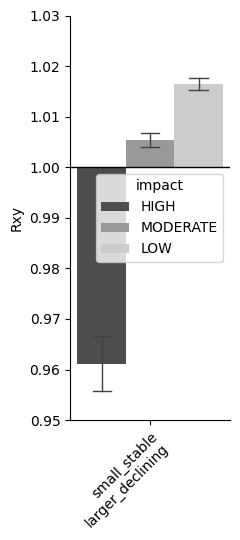

In [11]:
fig, axes = plt.subplots(figsize = (2.5, 5.5))
grey_palette = {"HIGH": "#4d4d4d",
                "MODERATE": "#999999",
                "LOW": "#cccccc"}

sns.barplot(data=df, x='xy_split', y='rxy_1', hue='impact', palette=grey_palette,
            ci='sd', errwidth=1, capsize = 0.1)
plt.axhline(0, color='black', linewidth=1)

# re-adjust y-axis labels to show Rxy
yticks = axes.get_yticks()
axes.set_yticks(yticks)
axes.set_yticklabels([f"{1 + y:.2f}" for y in yticks])

# label
axes.set_xlabel('')
# axes.set_ylabel('Rxy, small stable / larger declining')
axes.set_ylabel('Rxy')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')


sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()